In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyOne = MdpKernel()
mdpPolicyOne.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
mdpPolicyTwo = MdpKernel()
mdpPolicyTwo.load_policy(mdpKernelParams, policyMode="stochastic", randomR=False)

# ==== Prepare Simulator====
num_windows = 5000
obvMode = "predicted" # "perfect" or "predicted"

policySimulator = PolicySimulator(mdpPolicyOne, env)
simResultOne = policySimulator.runSimulation(mdpPolicyOne, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
'''
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultDeterministic['uRecord'], 
    simResultDeterministic['actionsRecord'], 
    simResultDeterministic['rewardRecord'], 
    simResultDeterministic['uNextRecord']
)
'''
num_windows = 5000
policySimulator = PolicySimulator(mdpPolicyTwo, env)
simResultTwo = policySimulator.runSimulation(mdpPolicyTwo, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
uRecord = np.concatenate((simResultOne['uRecord'], simResultTwo['uRecord']))
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultOne['uRecord'] + simResultTwo['uRecord'], 
    simResultOne['actionsRecord'] + simResultTwo['actionsRecord'], 
    simResultOne['rewardRecord'] + simResultTwo['rewardRecord'], 
    simResultOne['uNextRecord'] + simResultTwo['uNextRecord']
)

Simulation Progress: 100%|██████████| 5000/5000 [00:12<00:00, 405.13it/s, avg reward=0.011917]


In [4]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.1,
    'tau': 0.005,
    'lr': 5e-3,
    'eta': 1.0,
    'iql_tau': 0.95,
    'temperature': 3.0,
    'N_action_candidates': 100
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env, iql_flag=True, epochs=500,batch_size=1024, sample_method="greedy")

Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 115.02it/s]                                                            


Epoch   50/ 500  Avg Ld=0.324268  Avg Lq=33.072054  Avg loss_critic=0.005168  Test packet loss=0.2055  Avg Q_value_check=0.073931


Evaluation windows: 100%|██████████| 500/500 [00:05<00:00, 91.46it/s]                                                             


Epoch  100/ 500  Avg Ld=0.240456  Avg Lq=6.929249  Avg loss_critic=0.000724  Test packet loss=0.0256  Avg Q_value_check=0.115785


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 114.40it/s]                                                            


Epoch  150/ 500  Avg Ld=0.221258  Avg Lq=5.930080  Avg loss_critic=0.000423  Test packet loss=0.0174  Avg Q_value_check=0.105061


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 110.50it/s]                                                             


Epoch  200/ 500  Avg Ld=0.219227  Avg Lq=6.349893  Avg loss_critic=0.000774  Test packet loss=0.0079  Avg Q_value_check=0.108083


Evaluation windows: 100%|██████████| 500/500 [00:05<00:00, 86.16it/s]                                                             


Epoch  250/ 500  Avg Ld=0.212322  Avg Lq=5.771002  Avg loss_critic=0.000578  Test packet loss=0.0063  Avg Q_value_check=0.117035


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 109.93it/s]                                                            


Epoch  300/ 500  Avg Ld=0.209011  Avg Lq=5.512955  Avg loss_critic=0.000346  Test packet loss=0.0061  Avg Q_value_check=0.115528


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 116.65it/s]                                                            


Epoch  350/ 500  Avg Ld=0.206115  Avg Lq=5.972766  Avg loss_critic=0.000576  Test packet loss=0.0041  Avg Q_value_check=0.123110


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 106.72it/s]                                                            


Epoch  400/ 500  Avg Ld=0.204706  Avg Lq=5.419420  Avg loss_critic=0.000553  Test packet loss=0.0065  Avg Q_value_check=0.122486


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 117.57it/s]                                                            


Epoch  450/ 500  Avg Ld=0.199053  Avg Lq=5.319816  Avg loss_critic=0.000565  Test packet loss=0.0056  Avg Q_value_check=0.122247


Evaluation windows: 100%|██████████| 500/500 [00:04<00:00, 117.23it/s]                                                            

Epoch  500/ 500  Avg Ld=0.197786  Avg Lq=5.279966  Avg loss_critic=0.000560  Test packet loss=0.0051  Avg Q_value_check=0.122381


In [5]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")
with open(f'Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(diffusionQParams, f)
print(f"Params saved to Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl
Params saved to Results/DiffusionQ/diffusionQ_params_config0.pkl


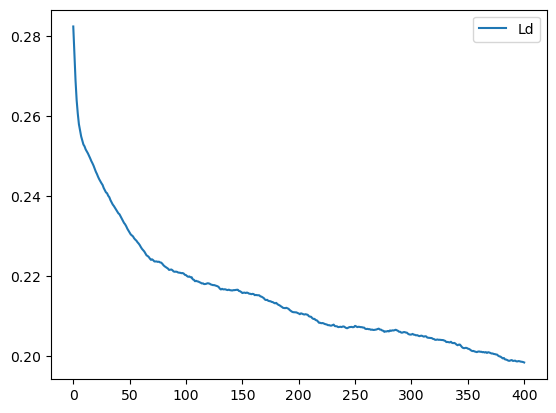

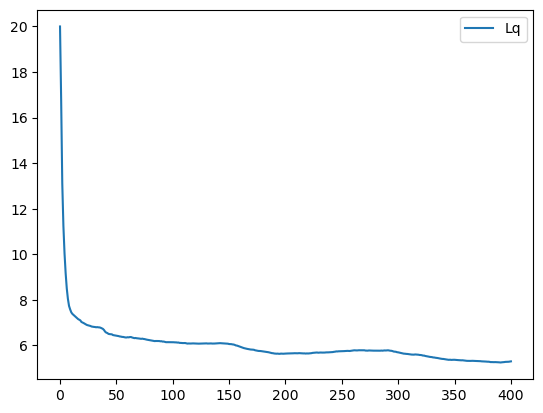

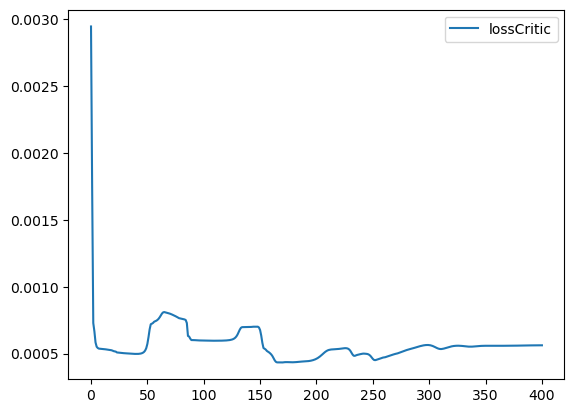

In [6]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -1000
window_size = 100
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()